<a href="https://colab.research.google.com/github/insaiyancvk/Dere-Net/blob/main/Dere_Net_dirty_work_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. See what data we got

## Plot sample data


In [ ]:
#@title
path = "./waifus/waifus_images/waifus_images_train/Dandere/Kosaki Onodera40.png"
w = cv2.imread(path, 3)
RGB_img = cv2.cvtColor(w, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [ ]:
#@title
RGB_img.shape, type(RGB_img)

((300, 168, 3), numpy.ndarray)

In [ ]:
#@title
TRAIN_PATH

'waifus\\waifus_images\\waifus_images_train'

In [ ]:
#@title
## Print out images
fig, axs = plt.subplots(7,5, figsize=(15,15), constrained_layout=True)
fig = plt.figure(figsize=(10,3))

for ax, row in zip(axs[:,0], class_list):
    ax.set_ylabel(row, rotation=90, fontsize=26)

a, b = 0, 0
for i in os.listdir(TRAIN_PATH):
    imgs = os.listdir(os.path.join(TRAIN_PATH, i))
    random.shuffle(imgs)
    for j in imgs:
        img2 = cv2.imread(os.path.join(TRAIN_PATH, i, j))
        try:
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        except:
            print(os.path.join(TRAIN_PATH, i, j))
            continue
        rm = axs[a][b].imshow(img2)
        plt.axis('off')
        rm.axes.get_xaxis().set_visible(False)
#         rm.axes.get_yaxis().set_visible(False)
        b+=1
        if b>4:
            b=0
            break
    a+=1
    if a>6:
        break

**NOTE:** Use image size: 224,224 or 256,256 ~(since we ain't got chad GPUs)~ we do 😏


## Import stuff

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, random, time

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")
BATCH = 64 #@param {type:"integer"}

Mounted at /content/drive
cuda activated.


# Preprocess the data

In [2]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && mkdir /content/waifus && cp /content/drive/MyDrive/kaggle/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle datasets download jahelsantiagoleon/female-anime-characters-anime-dataset 
print("Extracting the dataset")
!unzip -q female-anime-characters-anime-dataset.zip -d /content/waifus/ 

print("Initializing classes")

class_list = [
    'dandere',
    'deredere',
    'himdere',
    'kundere',
    'tsundere',
    'yandere',
    'yangire'
]

print("Creating folders for workspace")
drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "WAIFUS": os.path.join(drive,"waifus"),
    "TRAIN": os.path.join("waifus","waifus_images","waifus_images_train"),
    "TEST": os.path.join("waifus","waifus_images","waifus_images_val"),
    "WORKSPACE": os.path.join(drive,"waifus","Workspace"),
    "MODELS" : os.path.join(drive,"waifus","Workspace","Models"),
    "PERFORMANCE" : os.path.join(drive,"waifus","Workspace","Performance")
}

for key in FOLDERS:
    if not os.path.isdir("./"+FOLDERS[key]):
        print(key," directory doesn't exist. Creating one.")
        os.mkdir("./"+FOLDERS[key])
        print(key, " directory created.")
    else:
        print(key, "exists")

print("Transforming the waifu data")
transformations = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformations_test = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# returns image, label and path of the image
# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         path = self.imgs[index][0]
#         tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path

# train_dataset = ImageFolderWithPaths(root="./dataset/waifus/waifus_images/waifus_images_train/", transform = transformations)
print("Creating train dataloader")
train_dataset = datasets.ImageFolder(FOLDERS["TRAIN"], transform = transformations)
train_loader = DataLoader(train_dataset, batch_size = BATCH, shuffle=True)

# test_dataset = torchvision.datasets.ImageFolder(FOLDERS["TEST"], transform=transformations_test)
print("Creating test dataloader")
test_dataset = datasets.ImageFolder(FOLDERS["TEST"], transform = transformations)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH,
                                         shuffle=True)

print("Data preprocessing completed.")

Initializing kaggle
 97% 673M/693M [00:27<00:00, 23.7MB/s]
100% 693M/693M [00:27<00:00, 26.3MB/s]
Extracting the dataset
Initializing classes
Creating folders for workspace
WAIFUS exists
TRAIN exists
TEST exists
WORKSPACE exists
MODELS exists
PERFORMANCE exists
Transforming the waifu data
Creating train dataloader
Creating test dataloader
Data preprocessing completed.


## The Model:

[Useful stuff](https://medium.com/@iamvarman/how-to-calculate-the-number-of-parameters-in-the-cnn-5bd55364d7ca#) for CNN 

In [3]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(5, 5)
        
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3)
        
        self.fc1 = nn.Linear(16, 500)
        self.fc2 = nn.Linear(500, 350)
        self.fc3 = nn.Linear(350, 200)
        self.fc4 = nn.Linear(200, 50)
        self.fc5 = nn.Linear(50, 7)

    def forward(self, x):
        
        # Conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        #print("Tensor shape: ",x.shape)
        
        # Flatten the batch
        x = x.view(x.size(0),-1)
        #print(x.shape)
        
        # Dense layer 1
        x = F.relu(self.fc1(x))
        # 2
        x = F.relu(self.fc2(x))
        # 3
        x = F.relu(self.fc3(x))
        # 4
        x = F.relu(self.fc4(x))
        # 5
        x = self.fc5(x)
        
        return x

In [6]:
net = Net()
items = iter(train_loader)
image, label = items.next()
preds = net(image[0].unsqueeze(0))

In [14]:
for name, param in net.named_parameters():
    print(name,'\t\t', param.shape)

conv1.weight 		 torch.Size([6, 3, 7, 7])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([16, 6, 5, 5])
conv2.bias 		 torch.Size([16])
conv3.weight 		 torch.Size([16, 16, 3, 3])
conv3.bias 		 torch.Size([16])
fc1.weight 		 torch.Size([500, 16])
fc1.bias 		 torch.Size([500])
fc2.weight 		 torch.Size([50, 500])
fc2.bias 		 torch.Size([50])
fc3.weight 		 torch.Size([7, 50])
fc3.bias 		 torch.Size([7])


In [ ]:
#@title
# Testing if all the parameters of the NN are set properly

image, label, p = items.next()
x = net(image[0].unsqueeze(0))
# print(x.shape)
f = plt.imshow(np.transpose(image[0], (1,2,0)));
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.title(
    "Name: "+''.join([i for i in os.path.splitext(os.path.basename(p[0]))[0] if not i.isdigit()])+"\n"+
    "Predicted: "+class_list[x.cpu().data.numpy().argmax()]+"\n"+"Actual: "+class_list[label[0].item()+1],
    loc='center'
);

## Steps
- pass imgae to the NN
- calculate loss
- backprop
- update weights

In [ ]:
#@title
def train_step(model, images, labels, loss_func, optim, device):
    
    # Set the gradiant values to zero because torch accumulates the values
    optim.zero_grad()
    
    # Predictions from the model
    outputs = model(images.to(device))
    
    # Calculate the loss
    loss = loss_func(outputs, labels.to(device))
    
    # Finds the derivative by applying chain rule
    loss.backward()
    
    # Move the loss function towards the local/global minima
    optim.step()
    
    # return the outputs and loss by moving them to CPU
    return outputs.cpu().detach().numpy(), loss.cpu().item()

In [ ]:
#@title
def epoch(model, train_loader, loss_func, optim, device):
    mean_loss = 0
    model = model.to(device)
    for image, label in tqdm(train_loader):
        loss = train_step(model, image, label, loss_func, optim, device)
        mean_loss += loss/len(train_loader)
    return mean_loss

5. Build a training loop
    1. Move to GPU
    2. Define the training function
    3. Calculate the running loss and store the same in list and later convert to np array and save the np array.
    4. Calculate the accuracy after every batch. Calculate the average of same and store the values in a list 
       and later convert it to np array and save theh np array.
    5. After every epoch, test the model loss and accuracy 
       (by following the same steps as done for training ie, move to list, convert to np array, save the np array) with the test data.


In [4]:
def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0

  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train()

  for image, label in tqdm(train_loader):

      optim.zero_grad()
      
      output = model(image.to(device))
      
      loss = loss_func(
        output,
        label.to(device)
        )
      
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
   
  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))

      loss = loss_func(
        output,
        label.to(device)
      )

      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy

  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [5]:
#@title Model Hyperparameters
EPOCH = 20 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
# Change LR dynamically
# LR = 0.015 #@param {type:"number"}

In [11]:
NAME = f"{BATCH}bat{EPOCH}epochLR{str(str(optimizer.param_groups[0]['lr']).replace('0.','')).replace('0.','')}"
# LRs = [0.15, 0.015, 0.0015, 0.001]
LRs = [0.0015]
its = [i for i in range(0,EPOCH,EPOCH//len(LRs))]
net =  Net()
net = net.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LRs[0], momentum=MOMENTUM)

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  if ep in its:
    print(f"Setting LR to {LRs[its.index(ep)]}")
    optimizer.param_groups[0]['lr'] = LRs[its.index(ep)]
  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  vals = epoch(net, test_loader, train_loader, loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  if len(test_loss_vals)>2:
    if test_loss_vals[-2]>test_loss_vals[-1]:
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      print(f"The loss has decreased :) saving the model to {model_name}\n")
      torch.save(net.state_dict(),model_name)

print(f"Total time taken to train for {EPOCH} epochs: {(time.time()-start)/60:.2f} min(s)")

Setting LR to 0.0015
Epoch: 1/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 2/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 3/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 4/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 5/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 6/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 7/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 8/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 9/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 10/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 11/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 12/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 13/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 14/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 15/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 16/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 17/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Epoch: 18/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 19/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



The loss has decreased :) saving the model to drive/MyDrive/waifus/Workspace/Models/32bat20epochLR0015.pth

Epoch: 20/20
LR: 0.0015
		Training the Neural Network



		Validating Neural Network



Total time taken to train for 20 epochs: 33.46 min(s)


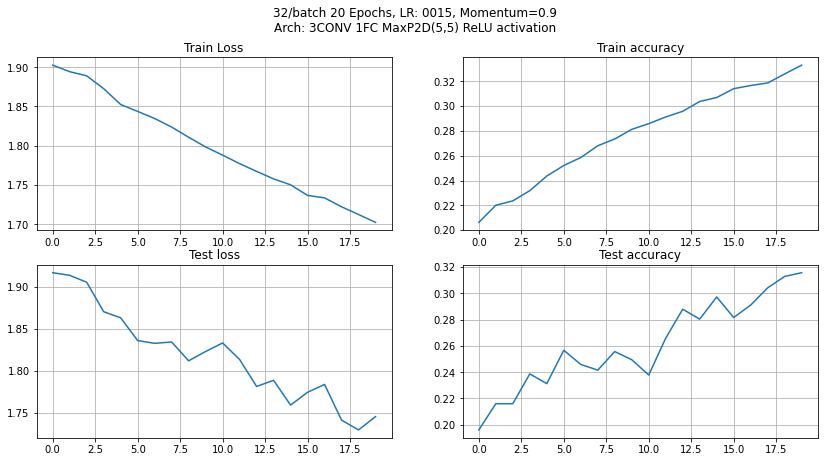

In [12]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"{BATCH}/batch {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}, Momentum={MOMENTUM}\nArch: 3CONV 1FC MaxP2D(5,5) ReLU activation\n")
plt.show()
fig.savefig(f"{FOLDERS['PERFORMANCE']}/.jpg")

In [ ]:
while True:
  time.sleep(500)

In [ ]:
#@title Save a model to resume later (_snippet_)
# Save the model
torch.save({
    'epoch': EPOCH,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': LOSS
}, 
    PATH+MODEL1)

In [ ]:
#@title Load a saved model to resume (_snippet_)
# Load the saved model
checkpoint = torch.load(PATH+MODEL1)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

(-0.5, 1007.5, 503.5, -0.5)

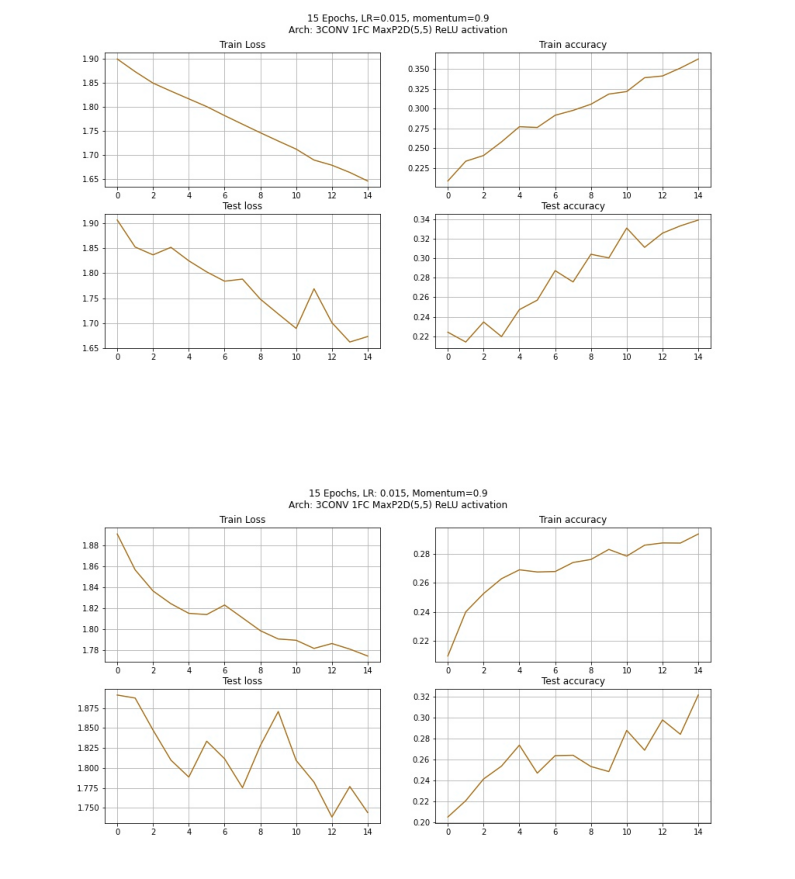

In [ ]:
LR0015graph = cv2.imread("/content/drive/MyDrive/waifus/Workspace/Performance/15epoch(.0015LR).jpg")
LR015graph = cv2.imread("/content/drive/MyDrive/waifus/Workspace/Performance/15epochLR015.jpg")
LRfig, LRaxs = plt.subplots(2, figsize=(14,16));
LRaxs[0].imshow(LR0015graph)
LRaxs[1].imshow(LR015graph)
LRaxs[0].axis("off")
LRaxs[1].axis("off")

## To improve the model, try these first:

- Add some filters to data
- Change batch size
- Change Learning rate
- Change momentum